In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadjunaidakram","key":"fa8c3b6858336c135bf8957f7875da76"}'}

In [3]:
!mkdir ~/.kaggle #created at root folder in colab

In [4]:
#copy
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
#!kaggle datasets download -d puneet6060/intel-image-classification

 99% 1.13G/1.14G [00:06<00:00, 253MB/s]
100% 1.14G/1.14G [00:06<00:00, 200MB/s]


In [6]:
#unzip dataset in colab session
!unzip -q covid19-radiography-database.zip # -q for quiet 

In [7]:
from keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.models import Sequential
import numpy as np
import glob
import matplotlib.pyplot as plt

In [8]:
IMAGE_SIZE = [150, 150]
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = le = True


# our layers - you can add more if you want
layer1 = Flatten()(vgg.output)
layer2 = Dense(64, activation='relu')(layer1)
prediction = Dense(3, activation='softmax')(layer2)
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

from keras.optimizers import SGD
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
# view the structure of the model
model.summary()
model.compile(
  loss='categorical_crossentropy',
  optimizer= sgd,
  metrics=['accuracy']
)

58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_test_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                                  validation_split = 0.20)


training_set = train_test_datagen.flow_from_directory("/content/COVID-19 Radiography Database/",
                                       batch_size = 64,
                                       target_size = (150, 150),
                                       shuffle = True,
                                       subset = "training",
                                       class_mode='categorical')

test_set = train_test_datagen.flow_from_directory("/content/COVID-19 Radiography Database/",
                                   batch_size = 64,
                                   target_size = (150, 150),
                                   shuffle = False,
                                   subset = "validation",
                                   class_mode='categorical')



Found 3109 images belonging to 3 classes.
Found 777 images belonging to 3 classes.


In [10]:
r = model.fit_generator(generator=training_set,
                        validation_data=test_set,
                        epochs = 15,
                        steps_per_epoch = len(training_set),
                        validation_steps = len(test_set))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
49/49 [==============================] - 67s 1s/step - loss: 0.8904 - accuracy: 0.5897 - val_loss: 0.3931 - val_accuracy: 0.8945
Epoch 2/15
49/49 [==============================] - 60s 1s/step - loss: 0.3535 - accuracy: 0.9014 - val_loss: 0.3188 - val_accuracy: 0.8867
Epoch 3/15
49/49 [==============================] - 59s 1s/step - loss: 0.2970 - accuracy: 0.9091 - val_loss: 0.2635 - val_accuracy: 0.9086
Epoch 4/15
49/49 [==============================] - 60s 1s/step - loss: 0.2851 - accuracy: 0.8958 - val_loss: 0.2212 - val_accuracy: 0.9241
Epoch 5/15
49/49 [==============================] - 60s 1s/step - loss: 0.2520 - accuracy: 0.9222 - val_loss: 0.2212 - val_accuracy: 0.9228
Epoch 6/15
49/49 [==============================] - 60s 1s/step - loss: 0.2381 - accuracy: 0.9147 - val_loss: 0.2288 - val_accuracy: 0.9099
Epoch 7/15
49/49 [==============================] - 60s 1s/step - loss: 0.2103 - accuracy: 0.9402 - val_loss: 0.2116 - val_accuracy: 0.9279
Epoch 8/15
49/49 [==

In [11]:
# save the model's trained weights
#model.save_weights('sequential_model_project_weights_try2.h5')
#!cp "/content/sequential_model_project_weights_try2.h5" "/content/drive/MyDrive/"

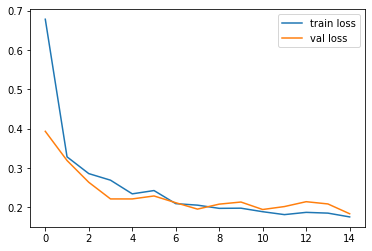

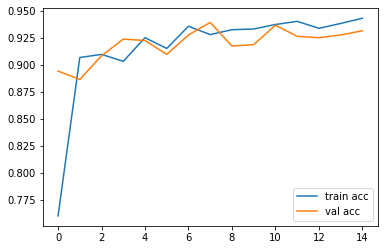

<Figure size 432x288 with 0 Axes>

In [12]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [13]:
pred_original_labels = test_set.classes

pred_label = model.predict_generator(test_set)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [14]:
# Plotting the confusion matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(pred_label, axis=1)
class_labels = list(test_set.class_indices.keys()) 
report = metrics.classification_report(pred_original_labels, y_pred, target_names=class_labels)
print(report) 

print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))

                 precision    recall  f1-score   support

          COVID       1.00      0.97      0.99       240
         NORMAL       0.87      0.94      0.90       268
Viral Pneumonia       0.92      0.87      0.90       269

       accuracy                           0.93       777
      macro avg       0.93      0.93      0.93       777
   weighted avg       0.93      0.93      0.93       777

Confusion Matrix
[[233   3   4]
 [  0 251  17]
 [  0  34 235]]
